## Train Linear Head

In [ ]:
import os
import glob
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns

# 1) Configurations for device, paths, training parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_ROOT = "data/eurosat/eurosat/2750"  # Path to your data
BACKBONE_CKPT = "runs/barlow_twins_ssl4eo_rgb_100000_res50/checkpoints/barlow_epoch100.pt"  # Pretrained model checkpoint
CKPT_DIR = "runs/linear_probe_eurosat_new_metrics/checkpoints_linear_probe_new_metrics"  # Checkpoint save directory
LOG_DIR = "runs/linear_probe_eurosat_new_metrics"  # Tensorboard logs
NUM_EPOCHS = 100  # Number of epochs to train
BATCH_SIZE = 256  # Batch size for training and validation
LR = 0.01  # Learning rate
MOMENTUM = 0.9  # Momentum for SGD optimizer
WEIGHT_DECAY = 1e-4  # Regularization
NUM_CLASSES = 10  # Number of output classes (EuroSAT has 10)

# Create directories if not already existing
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# 2) Define class names for EuroSAT dataset
class_names = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
    "Industrial", "Pasture", "PermanentCrop", "Residential",
    "River", "SeaLake"
]

# 3) Image preprocessing pipeline (resize, crop, normalize)
mean = [0.48241806, 0.48080587, 0.47794071]
std = [0.19021621, 0.16879530, 0.14623168]
preproc = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# 4) Dataset wrapper for EuroSAT images (JPG format)
class EuroSATJPG(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.transform = transform
        self.paths = glob.glob(os.path.join(root_dir, "*", "*.jpg"))
        self.paths.sort()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = os.path.basename(os.path.dirname(path))  # Folder name as label
        y = class_names.index(label)  # Convert label to index
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)  # Apply transformation
        return img, y

# 5) DataLoader for training and validation
ds = EuroSATJPG(DATA_ROOT, transform=preproc)
n = len(ds)
n_train = int(0.8 * n)  # 80% for training
train_ds, val_ds = torch.utils.data.random_split(ds, [n_train, n - n_train])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 6) Save the validation dataset images and labels
def save_dataset(dataset, filename):
    """Save dataset images and their labels as tensors."""
    data = []
    labels = []
    for img, label in dataset:
        data.append(img)
        labels.append(label)
    
    # Convert lists to tensors
    data_tensor = torch.stack(data)  # Stack images into a single tensor
    labels_tensor = torch.tensor(labels)  # Convert labels to tensor
    
    # Save tensors to file
    torch.save((data_tensor, labels_tensor), filename)

# Save validation dataset
save_dataset(val_ds, "val_dataset.pth")

# 7) Load the pre-trained backbone (ResNet-50)
feat_dim = 2048  # Feature dimension after the backbone
encoder = models.resnet50(pretrained=True)
encoder.fc = nn.Identity()  # Remove the final classification layer
ckpt = torch.load(BACKBONE_CKPT, map_location=DEVICE)  # Load the checkpoint
state = {k.replace("backbone.", ""): v for k, v in ckpt["model_state_dict"].items() if k.startswith("backbone.")}
encoder.load_state_dict(state, strict=True)  # Load the weights into the encoder
encoder.to(DEVICE).eval()  # Set to evaluation mode
for p in encoder.parameters():
    p.requires_grad = False  # Freeze encoder weights

# 8) Define the linear head for classification
head = nn.Linear(feat_dim, NUM_CLASSES).to(DEVICE)

# 9) Loss function, optimizer, learning rate scheduler, and TensorBoard writer
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.SGD(head.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)  # Optimizer
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Learning rate scheduler
writer = SummaryWriter(log_dir=LOG_DIR)  # TensorBoard logging

# --- Projector config for embeddings ---
metadata_path = os.path.join(LOG_DIR, "metadata.tsv")
with open(metadata_path, "w") as f:
    f.write("Label\n")  # Header for the metadata file
projector_config = f"""
embeddings {{
  tensor_name: "LinearProbe/Embeddings"
  metadata_path: "{os.path.basename(metadata_path)}"
}}
"""
with open(os.path.join(LOG_DIR, "projector_config.pbtxt"), "w") as f:
    f.write(projector_config)

# 10) Training and Validation Loop
best_val_acc = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    # -- Training --
    head.train()  # Set the head to training mode
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for x, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{NUM_EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.no_grad():
            feats = encoder(x)  # Extract features from the encoder
        logits = head(feats)  # Pass features through the linear head
        loss = criterion(logits, y)  # Compute loss
        optimizer.zero_grad()  # Zero gradients before backward pass
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update weights

        running_loss += loss.item() * y.size(0)
        pred = logits.argmax(dim=1)  # Get the predicted class
        correct += (pred == y).sum().item()  # Count correct predictions
        total += y.size(0)
        all_preds.append(pred.cpu())
        all_labels.append(y.cpu())

    # Compute and log training metrics
    train_loss = running_loss / total
    train_acc = correct / total
    scheduler.step()  # Update learning rate
    writer.add_scalar("LinearProbe/Train_Loss", train_loss, epoch)
    writer.add_scalar("LinearProbe/Train_Acc", train_acc, epoch)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    writer.add_scalar("LinearProbe/Train_Precision", precision_score(all_labels, all_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Train_Recall", recall_score(all_labels, all_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Train_F1", f1_score(all_labels, all_preds, average='weighted', zero_division=1), epoch)

    # -- Validation --
    head.eval()  # Set the head to evaluation mode
    correct, total = 0, 0
    all_feats, all_preds_list, all_labels_list, all_imgs = [], [], [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            feats = encoder(x)
            logits = head(feats)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            # Collect data for visualization
            all_feats.append(feats.cpu())
            all_preds_list.append(pred.cpu())
            all_labels_list.append(y.cpu())
            all_imgs.append(x.cpu())

    val_acc = correct / total
    writer.add_scalar("LinearProbe/Val_Acc", val_acc, epoch)

    # -- Validation Metrics --
    val_preds = torch.cat(all_preds_list)
    val_labels = torch.cat(all_labels_list)
    writer.add_scalar("LinearProbe/Val_Precision", precision_score(val_labels, val_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Val_Recall", recall_score(val_labels, val_preds, average='weighted', zero_division=1), epoch)
    writer.add_scalar("LinearProbe/Val_F1", f1_score(val_labels, val_preds, average='weighted', zero_division=1), epoch)

    # --- Embedding-Logging (subsampled) ---
    feats_cat = torch.cat(all_feats)
    labels_cat = torch.cat(all_labels_list)

    # Subsampling to limit the number of embeddings for visualization
    max_pts = 1000
    if feats_cat.size(0) > max_pts:
        idx = torch.randperm(feats_cat.size(0))[:max_pts]
        feats_sample = feats_cat[idx]
        labels_sample = labels_cat[idx].tolist()
    else:
        feats_sample = feats_cat
        labels_sample = labels_cat.tolist()

    writer.add_embedding(
        mat=feats_sample,
        metadata=labels_sample,
        global_step=epoch,
        tag="LinearProbe/Embeddings"
    )

    # --- t-SNE visualization ---
    tsne = TSNE(n_components=2)
    feats_2d = tsne.fit_transform(feats_sample.numpy())
    fig_tsne, ax_tsne = plt.subplots()
    ax_tsne.scatter(feats_2d[:, 0], feats_2d[:, 1], c=labels_sample, s=5)
    ax_tsne.set_title(f"t-SNE Val (Epoch {epoch})")
    writer.add_figure("LinearProbe/tSNE_Val", fig_tsne, epoch)
    plt.close(fig_tsne)

    # --- Confusion Matrix ---
    cm = confusion_matrix(labels_cat.tolist(), val_preds.tolist())
    fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names,
                ax=ax_cm)
    ax_cm.set_xlabel("Predicted")
    ax_cm.set_ylabel("True")
    writer.add_figure("LinearProbe/ConfusionMatrix_Val", fig_cm, epoch)
    plt.close(fig_cm)

    print(f"Epoch {epoch:03d} | Train: {train_loss:.4f}/{train_acc:.3f} | Val: {val_acc:.3f}")

    # -- Save best model checkpoint --
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        path = os.path.join(CKPT_DIR, f"best_head_epoch{epoch:03d}.pth")
        torch.save({"epoch": epoch, "head_state_dict": head.state_dict(), "val_acc": val_acc}, path)

# -- Save final model --
final_path = os.path.join(CKPT_DIR, "head_final.pth")
torch.save(head.state_dict(), final_path)
print(f"Final head saved at {final_path}")
writer.close()


2025-06-27 10:03:22.822146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751018602.845549    9731 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751018602.852276    9731 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751018602.870603    9731 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751018602.870623    9731 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751018602.870625    9731 computation_placer.cc:177] computation placer alr

Epoch 001 | Train: 12.7564/0.371 | Val: 0.621


[Train] Epoch 2/100: 100%|██████████| 85/85 [01:06<00:00,  1.28it/s]


Epoch 002 | Train: 3.4531/0.591 | Val: 0.613


[Train] Epoch 3/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 003 | Train: 2.7090/0.623 | Val: 0.543


[Train] Epoch 4/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 004 | Train: 1.5489/0.703 | Val: 0.717


[Train] Epoch 5/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 005 | Train: 1.6176/0.694 | Val: 0.697


[Train] Epoch 6/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 006 | Train: 2.1952/0.674 | Val: 0.601


[Train] Epoch 7/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 007 | Train: 1.4456/0.708 | Val: 0.727


[Train] Epoch 8/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 008 | Train: 1.1794/0.737 | Val: 0.757


[Train] Epoch 9/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 009 | Train: 2.8456/0.660 | Val: 0.703


[Train] Epoch 10/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 010 | Train: 1.2320/0.735 | Val: 0.757


[Train] Epoch 11/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 011 | Train: 1.1555/0.740 | Val: 0.641


[Train] Epoch 12/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 012 | Train: 1.8604/0.687 | Val: 0.620


[Train] Epoch 13/100:  99%|█████████▉| 84/85 [01:07<00:00,  1.30it/s]

Epoch 013 | Train: 2.2126/0.681 | Val: 0.780


[Train] Epoch 14/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 014 | Train: 0.9681/0.775 | Val: 0.702


[Train] Epoch 15/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 015 | Train: 1.6056/0.720 | Val: 0.744


[Train] Epoch 16/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 016 | Train: 1.3148/0.746 | Val: 0.665


[Train] Epoch 17/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 017 | Train: 1.3198/0.751 | Val: 0.774


[Train] Epoch 18/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 018 | Train: 1.1692/0.751 | Val: 0.607


[Train] Epoch 19/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 019 | Train: 1.0311/0.772 | Val: 0.779


[Train] Epoch 20/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 020 | Train: 1.0303/0.772 | Val: 0.581


[Train] Epoch 21/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 021 | Train: 1.2650/0.746 | Val: 0.789


[Train] Epoch 22/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 022 | Train: 0.9066/0.784 | Val: 0.736


[Train] Epoch 23/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 023 | Train: 0.8928/0.786 | Val: 0.806


[Train] Epoch 24/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 024 | Train: 0.8556/0.789 | Val: 0.754


[Train] Epoch 25/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 025 | Train: 1.1036/0.767 | Val: 0.752


[Train] Epoch 26/100: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]


Epoch 026 | Train: 0.7979/0.796 | Val: 0.657


[Train] Epoch 27/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 027 | Train: 1.0919/0.766 | Val: 0.827


[Train] Epoch 28/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 028 | Train: 1.0186/0.775 | Val: 0.784


[Train] Epoch 29/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 029 | Train: 1.0379/0.782 | Val: 0.709


[Train] Epoch 30/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 030 | Train: 1.0158/0.768 | Val: 0.822


[Train] Epoch 31/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 031 | Train: 0.4913/0.856 | Val: 0.855


[Train] Epoch 32/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 032 | Train: 0.4572/0.859 | Val: 0.855


[Train] Epoch 33/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 033 | Train: 0.4530/0.861 | Val: 0.855


[Train] Epoch 34/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 034 | Train: 0.4485/0.861 | Val: 0.852


[Train] Epoch 35/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 035 | Train: 0.4406/0.863 | Val: 0.849


[Train] Epoch 36/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 036 | Train: 0.4431/0.861 | Val: 0.852


[Train] Epoch 37/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 037 | Train: 0.4371/0.863 | Val: 0.851


[Train] Epoch 38/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 038 | Train: 0.4352/0.864 | Val: 0.856


[Train] Epoch 39/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 039 | Train: 0.4336/0.865 | Val: 0.857


[Train] Epoch 40/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 040 | Train: 0.4281/0.864 | Val: 0.859


[Train] Epoch 41/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 041 | Train: 0.4310/0.865 | Val: 0.856


[Train] Epoch 42/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 042 | Train: 0.4258/0.864 | Val: 0.851


[Train] Epoch 43/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 043 | Train: 0.4247/0.865 | Val: 0.849


[Train] Epoch 44/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 044 | Train: 0.4253/0.864 | Val: 0.846


[Train] Epoch 45/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 045 | Train: 0.4217/0.865 | Val: 0.854


[Train] Epoch 46/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 046 | Train: 0.4266/0.863 | Val: 0.851


[Train] Epoch 47/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 047 | Train: 0.4202/0.866 | Val: 0.860


[Train] Epoch 48/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 048 | Train: 0.4198/0.865 | Val: 0.860


[Train] Epoch 49/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 049 | Train: 0.4140/0.867 | Val: 0.858


[Train] Epoch 50/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 050 | Train: 0.4132/0.866 | Val: 0.854


[Train] Epoch 51/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 051 | Train: 0.4125/0.866 | Val: 0.856


[Train] Epoch 52/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 052 | Train: 0.4116/0.867 | Val: 0.851


[Train] Epoch 53/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 053 | Train: 0.4110/0.868 | Val: 0.854


[Train] Epoch 54/100: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]


Epoch 054 | Train: 0.4060/0.869 | Val: 0.856


[Train] Epoch 55/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 055 | Train: 0.4047/0.869 | Val: 0.854


[Train] Epoch 56/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 056 | Train: 0.4033/0.870 | Val: 0.851


[Train] Epoch 57/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 057 | Train: 0.4088/0.867 | Val: 0.854


[Train] Epoch 58/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 058 | Train: 0.4061/0.866 | Val: 0.853


[Train] Epoch 59/100: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]


Epoch 059 | Train: 0.4038/0.868 | Val: 0.857


[Train] Epoch 60/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 060 | Train: 0.4003/0.870 | Val: 0.857


[Train] Epoch 61/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 061 | Train: 0.3912/0.871 | Val: 0.863


[Train] Epoch 62/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 062 | Train: 0.3892/0.871 | Val: 0.862


[Train] Epoch 63/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 063 | Train: 0.3888/0.873 | Val: 0.862


[Train] Epoch 64/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 064 | Train: 0.3886/0.872 | Val: 0.863


[Train] Epoch 65/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 065 | Train: 0.3886/0.872 | Val: 0.862


[Train] Epoch 66/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 066 | Train: 0.3888/0.872 | Val: 0.862


[Train] Epoch 67/100: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]


Epoch 067 | Train: 0.3884/0.872 | Val: 0.864


[Train] Epoch 68/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 068 | Train: 0.3885/0.871 | Val: 0.863


[Train] Epoch 69/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 069 | Train: 0.3881/0.873 | Val: 0.862


[Train] Epoch 70/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 070 | Train: 0.3877/0.871 | Val: 0.863


[Train] Epoch 71/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 071 | Train: 0.3881/0.872 | Val: 0.862


[Train] Epoch 72/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 072 | Train: 0.3881/0.871 | Val: 0.862


[Train] Epoch 73/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 073 | Train: 0.3874/0.872 | Val: 0.861


[Train] Epoch 74/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 074 | Train: 0.3876/0.872 | Val: 0.862


[Train] Epoch 75/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 075 | Train: 0.3881/0.872 | Val: 0.862


[Train] Epoch 76/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 076 | Train: 0.3875/0.872 | Val: 0.860


[Train] Epoch 77/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 077 | Train: 0.3879/0.872 | Val: 0.863


[Train] Epoch 78/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 078 | Train: 0.3874/0.871 | Val: 0.862


[Train] Epoch 79/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 079 | Train: 0.3875/0.872 | Val: 0.863


[Train] Epoch 80/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 080 | Train: 0.3870/0.873 | Val: 0.864


[Train] Epoch 81/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 081 | Train: 0.3874/0.872 | Val: 0.863


[Train] Epoch 82/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 082 | Train: 0.3875/0.873 | Val: 0.863


[Train] Epoch 83/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 083 | Train: 0.3874/0.873 | Val: 0.862


[Train] Epoch 84/100: 100%|██████████| 85/85 [01:07<00:00,  1.27it/s]


Epoch 084 | Train: 0.3866/0.873 | Val: 0.863


[Train] Epoch 85/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 085 | Train: 0.3869/0.873 | Val: 0.861


[Train] Epoch 86/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 086 | Train: 0.3878/0.871 | Val: 0.863


[Train] Epoch 87/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 087 | Train: 0.3866/0.872 | Val: 0.863


[Train] Epoch 88/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 088 | Train: 0.3864/0.873 | Val: 0.861


[Train] Epoch 89/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 089 | Train: 0.3861/0.873 | Val: 0.862


[Train] Epoch 90/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 090 | Train: 0.3862/0.873 | Val: 0.862


[Train] Epoch 91/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 091 | Train: 0.3852/0.873 | Val: 0.862


[Train] Epoch 92/100: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]


Epoch 092 | Train: 0.3850/0.873 | Val: 0.863


[Train] Epoch 93/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 093 | Train: 0.3849/0.873 | Val: 0.863


[Train] Epoch 94/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 094 | Train: 0.3848/0.873 | Val: 0.863


[Train] Epoch 95/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 095 | Train: 0.3848/0.873 | Val: 0.863


[Train] Epoch 96/100: 100%|██████████| 85/85 [01:07<00:00,  1.26it/s]


Epoch 096 | Train: 0.3848/0.873 | Val: 0.864


[Train] Epoch 97/100: 100%|██████████| 85/85 [01:08<00:00,  1.25it/s]


Epoch 097 | Train: 0.3847/0.873 | Val: 0.863


[Train] Epoch 98/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 098 | Train: 0.3847/0.872 | Val: 0.863


[Train] Epoch 99/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 099 | Train: 0.3847/0.873 | Val: 0.863


[Train] Epoch 100/100: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 100 | Train: 0.3846/0.873 | Val: 0.863
Final head saved at runs/linear_probe_eurosat_new_metrics/checkpoints_linear_probe_new_metrics/head_final.pth


## Create Metrics

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Collage gespeichert als collage_res50.png


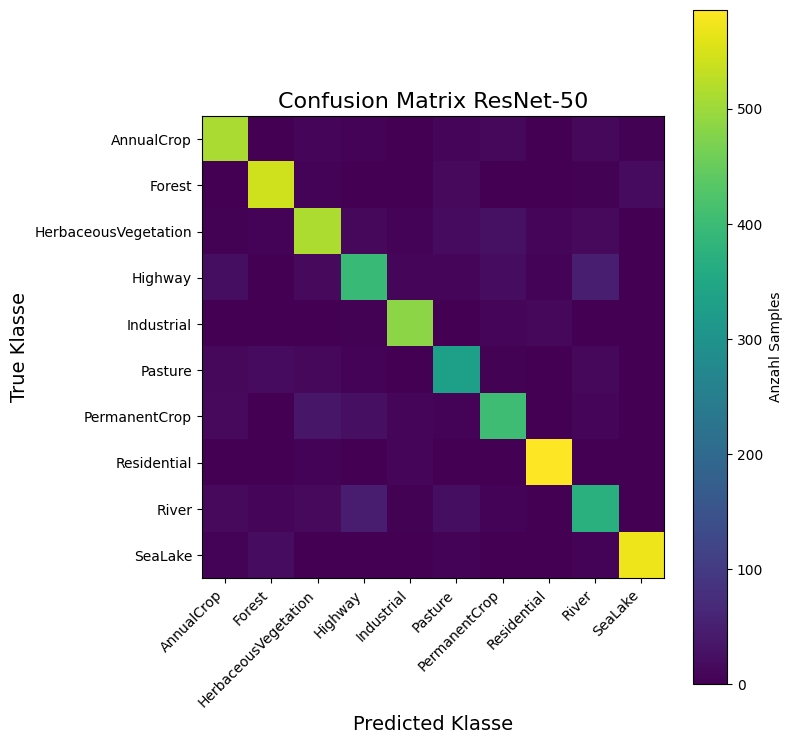

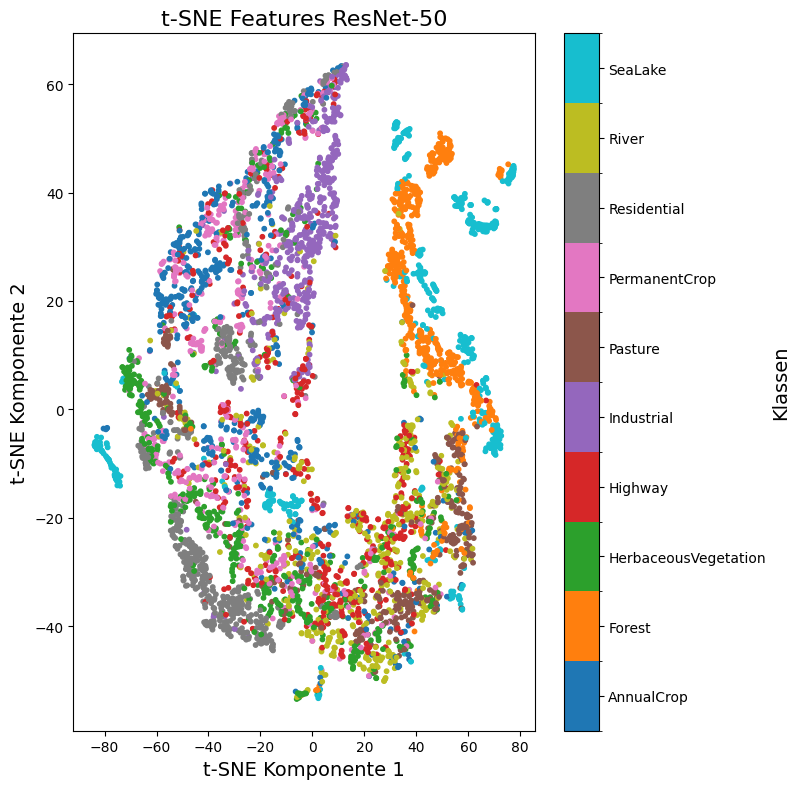

In [3]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import numpy as np
import random
import matplotlib.colors as mcolors

# --- Einstellungen ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

# Inverse-Normalisierung (für Anzeige)
mean = torch.tensor([0.48241806, 0.48080587, 0.47794071])
std  = torch.tensor([0.19021621, 0.16879530, 0.14623168])
def unnormalize(img_tensor):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
    return Image.fromarray(img)

# Transform für rohe Bilder
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# --- Encoder ResNet-50 laden ---
encoder = models.resnet50(pretrained=False)
encoder.fc = torch.nn.Identity()
encoder.to(device)
encoder.eval()
# SSL-Backbone laden
ckpt_ssl = torch.load(
    "runs/barlow_twins_ssl4eo_rgb_100000_res50/checkpoints/barlow_epoch100.pt",
    map_location=device
)
state = {k.replace("backbone.", ""): v for k, v in ckpt_ssl["model_state_dict"].items() if k.startswith("backbone.")}
encoder.load_state_dict(state, strict=True)

# Linear Head
feat_dim = 2048
head = torch.nn.Linear(feat_dim, len(class_names)).to(device)
ckpt_lp = torch.load(
    "runs/linear_probe_eurosat_new_metrics/checkpoints_linear_probe_new_metrics/head_final.pth",
    map_location=device
)
if "head_state_dict" in ckpt_lp:
    head.load_state_dict(ckpt_lp["head_state_dict"])
else:
    head.weight.data = ckpt_lp["weight"]
    head.bias.data   = ckpt_lp["bias"]
head.eval()

# --- Validation Data laden ---
val_data, val_labels = torch.load("val_dataset.pth", map_location=device)

# --- Zufällige Collage (optional) ---
num_samples = 20
indices = random.sample(range(len(val_data)), num_samples)
fig, axes = plt.subplots(4, 5, figsize=(15,12))
for ax, idx in zip(axes.flatten(), indices):
    x = val_data[idx].unsqueeze(0).to(device)
    true_label = val_labels[idx].item()
    with torch.no_grad():
        feats  = encoder(x)
        logits = head(feats)
        probs  = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()
    img_pil = unnormalize(x[0])
    ax.imshow(img_pil)
    ax.set_title(f"T:{class_names[true_label]} \nP:{class_names[pred]}({probs[0,pred]:.2f})")
    ax.axis('off')
plt.tight_layout()
plt.savefig("collage_res50.png", dpi=150, bbox_inches='tight')
plt.close()
print("Collage gespeichert als collage_res50.png")

# --- Inferenz über komplettes Val-Set ---
y_true, y_pred, features_list = [], [], []
for i in range(len(val_data)):
    x = val_data[i].unsqueeze(0).to(device)
    true = val_labels[i].item()
    with torch.no_grad():
        feat = encoder(x)
        logits = head(feat)
        probs = F.softmax(logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    y_true.append(true)
    y_pred.append(pred_label)
    features_list.append(feat.cpu().squeeze().numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap='viridis')
plt.title("Confusion Matrix ResNet-50", fontsize=16)
plt.xlabel("Predicted Klasse", fontsize=14)
plt.ylabel("True Klasse", fontsize=14)
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar(label="Anzahl Samples")
plt.tight_layout()
plt.savefig("confusion_matrix_res50.png", dpi=150, bbox_inches='tight')
plt.show()

# --- t-SNE mit Farb-Legende ---
features = np.stack(features_list)
tsne = TSNE(n_components=2, random_state=42)
z = tsne.fit_transform(features)
plt.figure(figsize=(8,8))
# Diskrete Farbkarte mit BoundaryNorm
cmap = plt.get_cmap('tab10', len(class_names))
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_names)+1)-0.5, ncolors=cmap.N)
scatter = plt.scatter(z[:,0], z[:,1], c=y_true, cmap=cmap, norm=norm, s=10)
plt.title("t-SNE Features ResNet-50", fontsize=16)
plt.xlabel("t-SNE Komponente 1", fontsize=14)
plt.ylabel("t-SNE Komponente 2", fontsize=14)
# Farbbar mit Klassennamen
cbar = plt.colorbar(scatter, ticks=np.arange(len(class_names)))
cbar.ax.set_yticklabels(class_names)
cbar.set_label("Klassen", fontsize=14)
plt.tight_layout()
plt.savefig("tsne_res50.png", dpi=150, bbox_inches='tight')
plt.show()


## Google Image Test

Vorhergesagte Klasse: Highway (Confidence: 0.77)


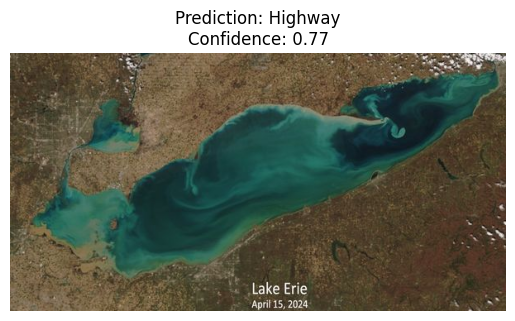

In [31]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from torchvision import models
import torch.nn as nn

# 1) Bild-Pfad anpassen
img_path = "google_images/lake2.jpg"  # Beispielbild-Pfad (dein eigenes Bild)

# 2) Transformationen anwenden (wie während des Trainings)
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48241806, 0.48080587, 0.47794071], std=[0.19021621, 0.16879530, 0.14623168]),
])

# 3) Bild laden und transformieren
img = Image.open(img_path).convert("RGB")  # Bild als RGB laden
img_tensor = transform(img).unsqueeze(0).to(device)  # Hinzufügen der Batch-Dimension und auf das Gerät verschieben

# 4) Encoder und Linear Head initialisieren (wie im Training)
feat_dim = 2048
NUM_CLASSES = 10  # EuroSAT-Klassenanzahl

encoder = models.resnet50(pretrained=True)
encoder.fc = nn.Identity()
encoder.to(device).eval()

BACKBONE_CKPT = "runs/barlow_twins_ssl4eo_rgb_100000_res50/checkpoints/barlow_epoch100.pt"
ckpt_ssl = torch.load(BACKBONE_CKPT, map_location=device)
state = {
    k.replace("backbone.", ""): v
    for k, v in ckpt_ssl["model_state_dict"].items()
    if k.startswith("backbone.")
}
encoder.load_state_dict(state, strict=True)

head = nn.Linear(feat_dim, NUM_CLASSES).to(device)
HEAD_CKPT = "checkpoints_linear_probe_new/head_final.pth"
ckpt_lp = torch.load(HEAD_CKPT, map_location=device)

# Lade Gewichtungen und Bias für den Head
head.weight.data = ckpt_lp["weight"]
head.bias.data = ckpt_lp["bias"]
head.eval()

# 5) Vorwärtsdurchlauf (Bild durch Modell leiten)
with torch.no_grad():
    features = encoder(img_tensor)  # Merkmale extrahieren
    logits = head(features)         # Durch den Linear Head
    probs = F.softmax(logits, dim=1)  # Softmax anwenden, um Wahrscheinlichkeiten zu erhalten

# 6) Vorhersage und Confidence
predicted_class_idx = probs.argmax(dim=1).item()  # Vorhergesagte Klasse
confidence = probs[0, predicted_class_idx].item()  # Confidence der Vorhersage

# 7) Ergebnis anzeigen
class_names = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", 
               "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]  # Klassen des EuroSAT-Datensatzes

print(f"Vorhergesagte Klasse: {class_names[predicted_class_idx]} (Confidence: {confidence:.2f})")

# 8) Bild anzeigen
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted_class_idx]}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()
